# 基于 dmc620 的实时内存带宽测量


## 单个文件处理

In [22]:
import pandas as pd
import numpy as np

perf_raw_data = pd.read_csv(perf_raw_path,
                            sep='|',
                            header=None, 
                            names=["timestamp", "value", "event"], 
                            usecols=[0, 1, 3])

perf_raw_data

,timestamp,value,event
0,1.001040,89742,"arm_dmc620_10008c000/clkdiv2_rdwr,mask=1,match=0/"
1,1.001040,90088,"arm_dmc620_10008c400/clkdiv2_rdwr,mask=1,match=0/"
2,1.001040,90306,"arm_dmc620_10008c800/clkdiv2_rdwr,mask=1,match=0/"
3,1.001040,88679,"arm_dmc620_10008cc00/clkdiv2_rdwr,mask=1,match=0/"
4,1.001040,86400,"arm_dmc620_10008d000/clkdiv2_rdwr,mask=1,match=0/"
...,...,...,...
41403,1295.736132,78358,"arm_dmc620_50008cc00/clkdiv2_rdwr,mask=1,match=1/"
41404,1295.736132,74592,"arm_dmc620_50008d000/clkdiv2_rdwr,mask=1,match=1/"
41405,1295.736132,74800,"arm_dmc620_50008d400/clkdiv2_rdwr,mask=1,match=1/"
41406,1295.736132,76833,"arm_dmc620_50008d800/clkdiv2_rdwr,mask=1,match=1/"


处理 event，从 event 中提取出：type 读写类型（read or write），device_id 即 dmc620 在 /sys/devices/ 的编号，socket 即 dmc620 设备所属的 socket

In [23]:
perf_raw_data['type'] = perf_raw_data['event'].apply(
    lambda x: 'read' if x[-2:-1] == '0' else 'write'
)
perf_raw_data['device_id'] = perf_raw_data['event'].apply(
    lambda x: x[11:20]
)
perf_raw_data['socket'] = perf_raw_data['device_id'].apply(
    lambda x: 0 if x[0] == '1' else '1'
)

perf_raw_data = perf_raw_data.drop('event', axis=1)
perf_raw_data

,timestamp,value,type,device_id,socket
0,1.001040,89742,read,10008c000,0
1,1.001040,90088,read,10008c400,0
2,1.001040,90306,read,10008c800,0
3,1.001040,88679,read,10008cc00,0
4,1.001040,86400,read,10008d000,0
...,...,...,...,...,...
41403,1295.736132,78358,write,50008cc00,1
41404,1295.736132,74592,write,50008d000,1
41405,1295.736132,74800,write,50008d400,1
41406,1295.736132,76833,write,50008d800,1


## 分析

系统整体带宽

对每个时间戳，聚合所有 device 的计数值，求和，乘以 64 再除以时间

【推测】这里一次 read 或 write 的数据量应该是 64 bits

In [24]:
bw_all = perf_raw_data.groupby(['timestamp']).agg(value=('value', 'sum')).reset_index()

bw_all['interval'] = bw_all['timestamp'].diff()
bw_all.loc[0, 'interval'] = bw_all.loc[0, 'timestamp']

bw_all['memory bandwidth (GB/s)'] = (bw_all['value'] * 64) / (bw_all['interval'] * 1000000000)

bw_all

,timestamp,value,interval,memory bandwidth (GB/s)
0,1.001040,4725632,1.001040,0.302126
1,2.003141,4853510,1.002102,0.309973
2,3.004872,7951353,1.001731,0.508007
3,4.006468,7390259,1.001596,0.472223
4,5.008005,1938660,1.001536,0.123884
...,...,...,...,...
1289,1292.443244,452195786,1.001490,28.897486
1290,1293.445512,243943784,1.002267,15.577082
1291,1294.447072,32977645,1.001561,2.107281
1292,1295.448550,16191894,1.001478,1.034752


单个 dmc620 内存带宽上限

3200 Mbps -- bits per second

3200 Mbps = 400 * 10^6 Byte per second = 381.47 MiB/s

整机 2 socket 共计 16 个 dmc620，合计最大带宽 6103.52 MiB/s

【和先前在 Ampere 上 STREAM 的测试结果差不多】

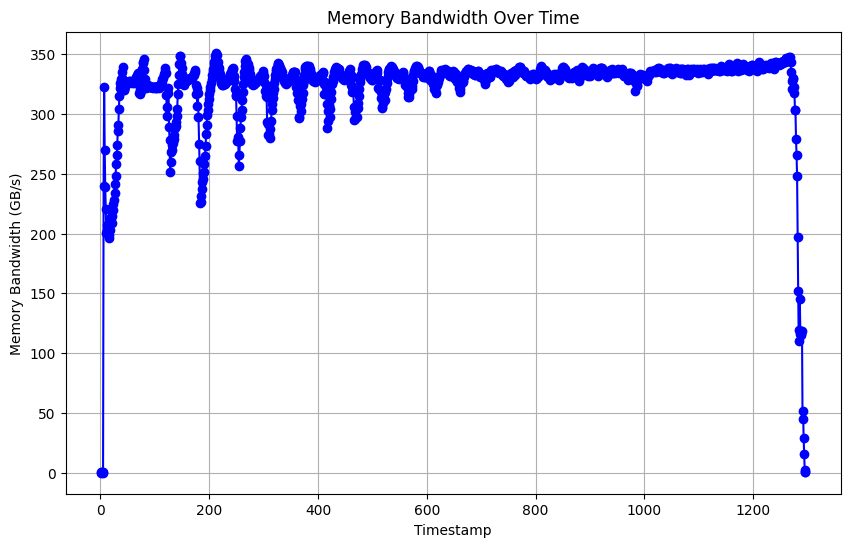

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(bw_all['timestamp'], bw_all['memory bandwidth (GB/s)'], marker='o', linestyle='-', color='b')
plt.title('Memory Bandwidth Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Memory Bandwidth (GB/s)')
plt.grid(True)
# plt.savefig('../data/images/memory_bandwidth.png')
plt.show()


## 批处理

In [13]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
csv_dir = "../data/csv/dmc_620/"
files = os.listdir(csv_dir)
print(files)

['500.perlbench_r_iter0_1732726637.csv', '500.perlbench_r_iter0_1732726864.csv', '500.perlbench_r_iter0_1732726973.csv', '502.gcc_r_iter0_1732729258.csv', '502.gcc_r_iter0_1732729345.csv', '502.gcc_r_iter0_1732729463.csv', '502.gcc_r_iter0_1732729593.csv', '502.gcc_r_iter0_1732729736.csv', '503.bwaves_r_iter0_1732756031.csv', '503.bwaves_r_iter0_1732756430.csv', '503.bwaves_r_iter0_1732757065.csv', '503.bwaves_r_iter0_1732757570.csv', '505.mcf_r_iter0_1732732987.csv', '507.cactuBSSN_r_iter0_1732763198.csv', '508.namd_r_iter0_1732765192.csv', '510.parest_r_iter0_1732768188.csv', '511.povray_r_iter0_1732775012.csv', '519.lbm_r_iter0_1732778962.csv', '520.omnetpp_r_iter0_1732738175.csv', '521.wrf_r_iter0_1732787811.csv', '523.xalancbmk_r_iter0_1732742640.csv', '525.x264_r_iter0_1732744818.csv', '525.x264_r_iter0_1732744864.csv', '525.x264_r_iter0_1732744989.csv', '526.blender_r_iter0_1732792925.csv', '527.cam4_r_iter0_1732794948.csv', '531.deepsjeng_r_iter0_1732746289.csv', '538.imagick_r

C:\Users\ERQI\AppData\Local\Temp\ipykernel_21128\1099088606.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 6))


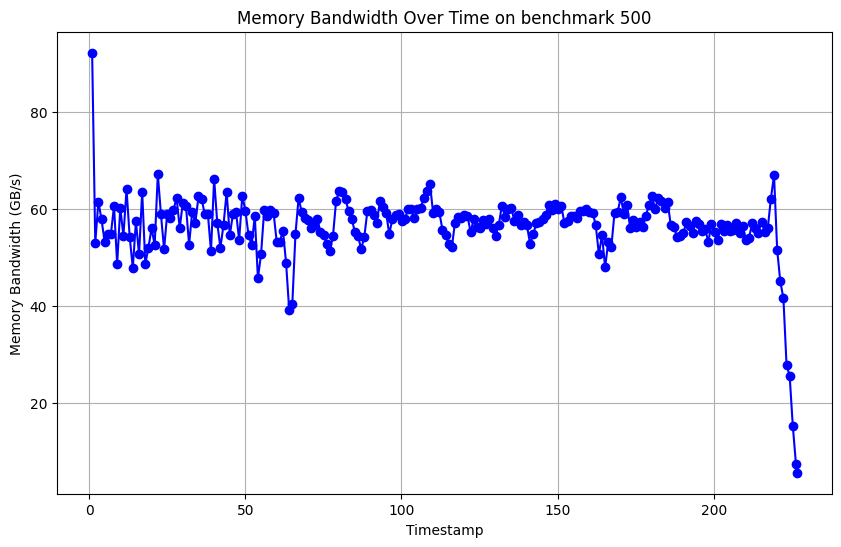

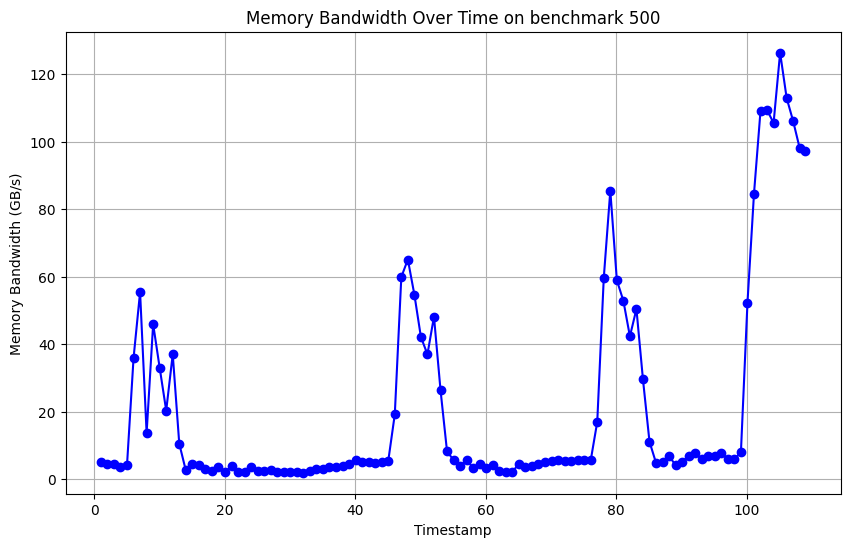

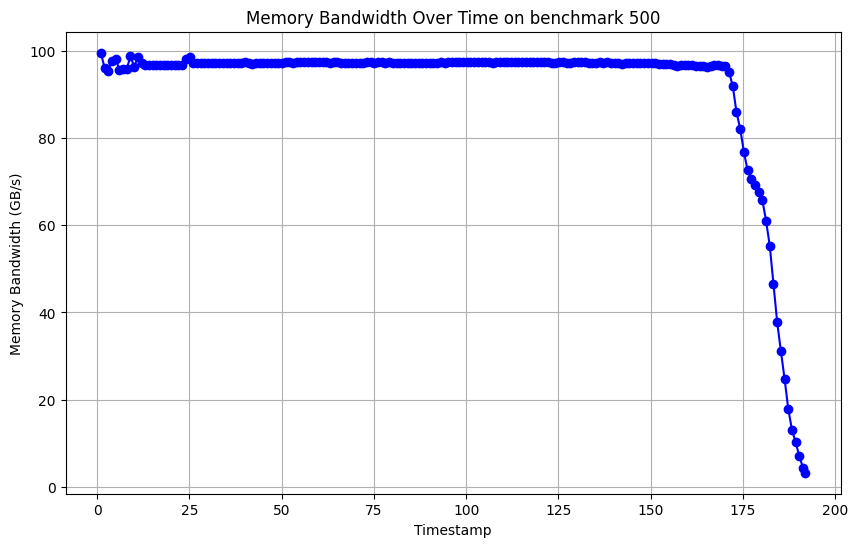

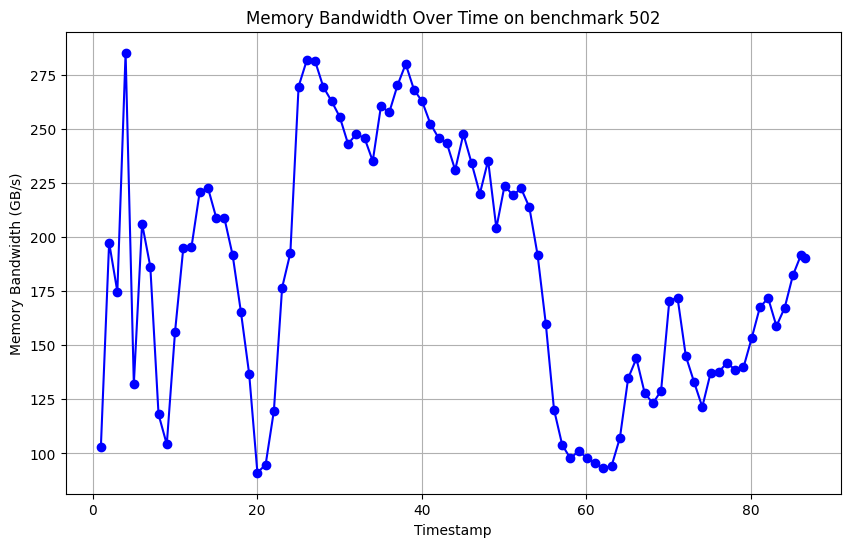

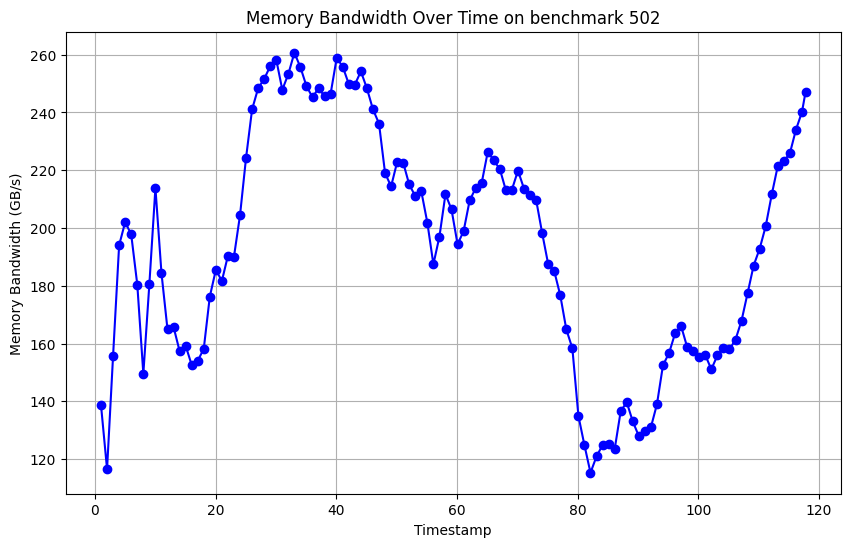

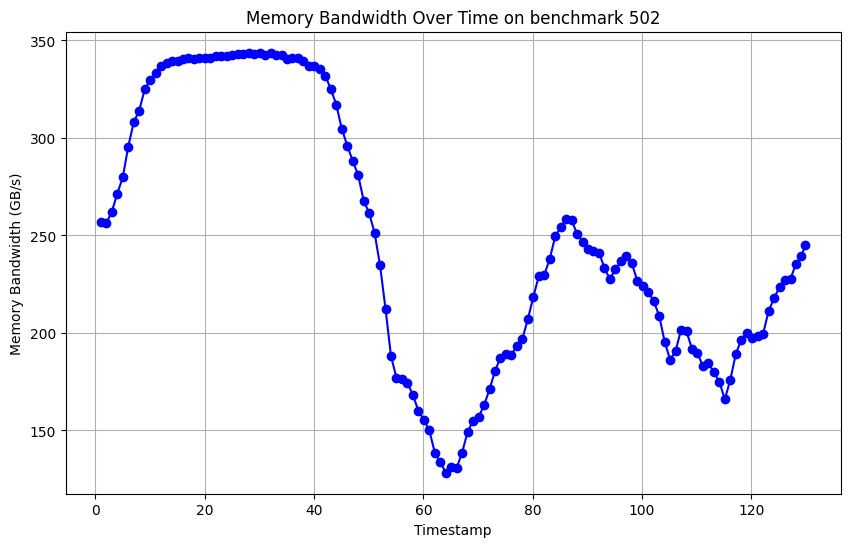

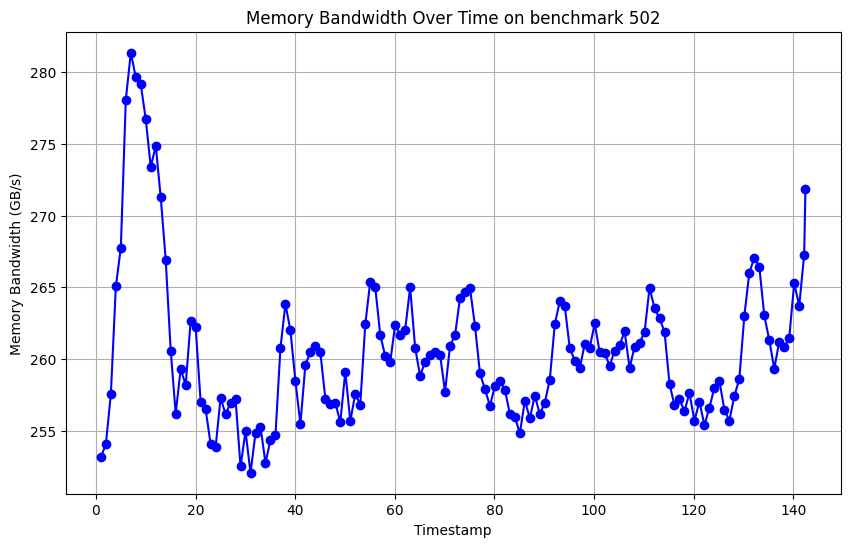

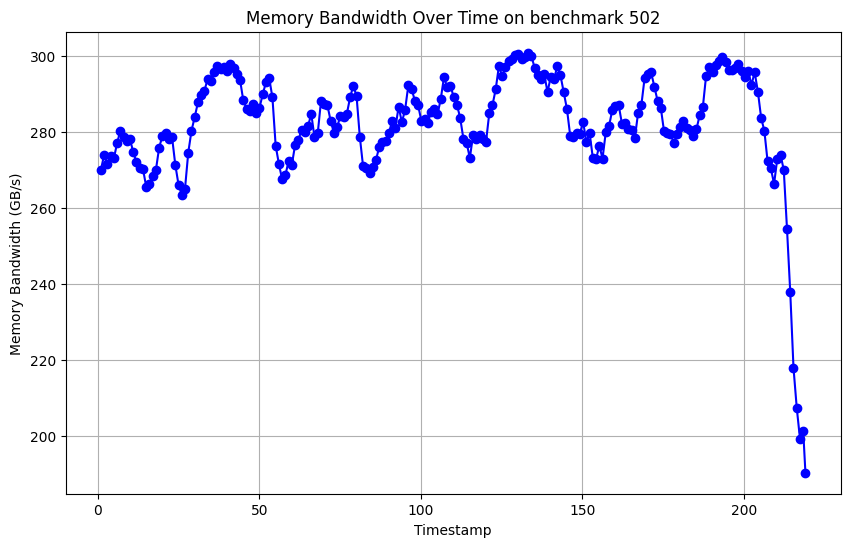

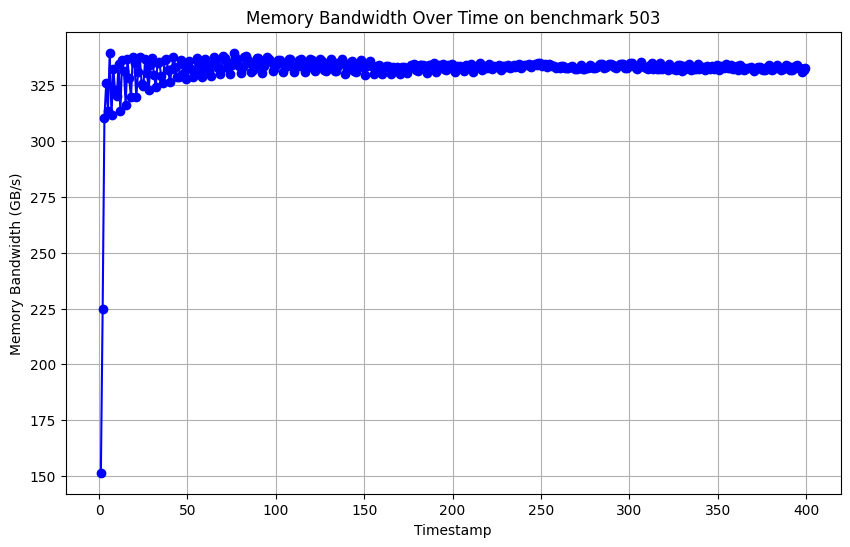

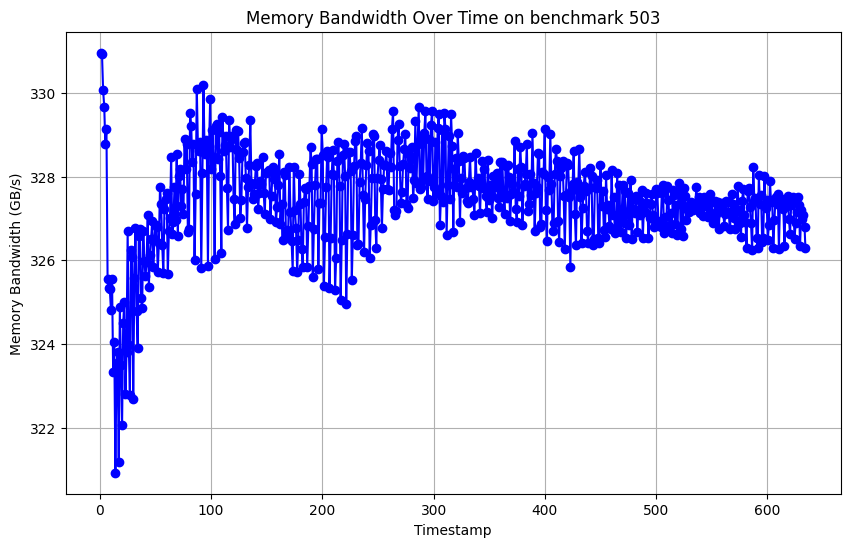

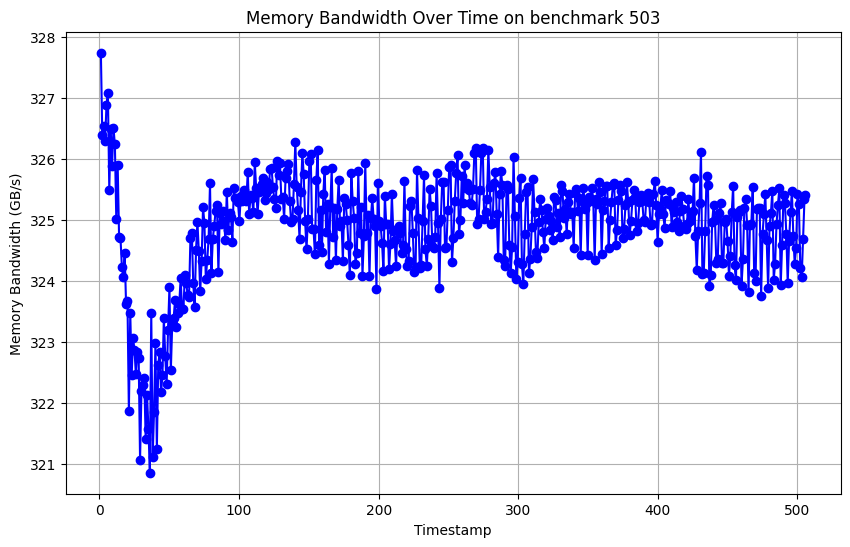

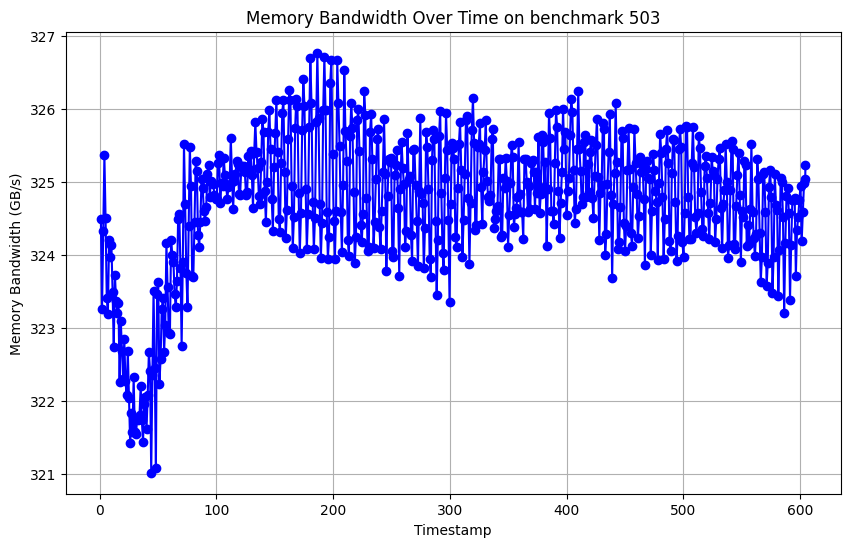

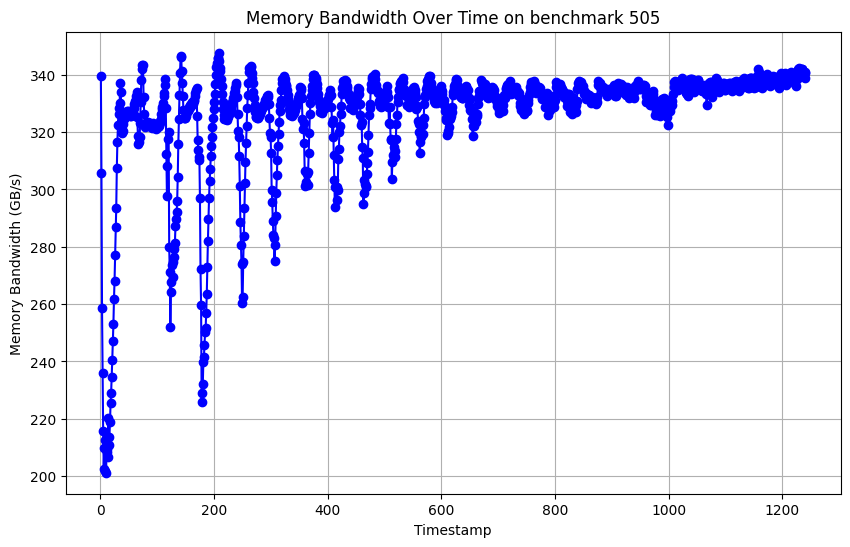

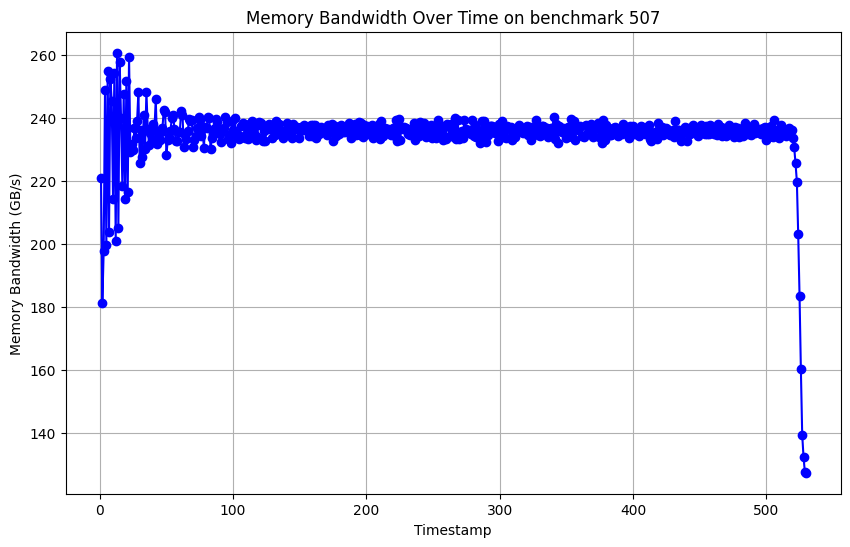

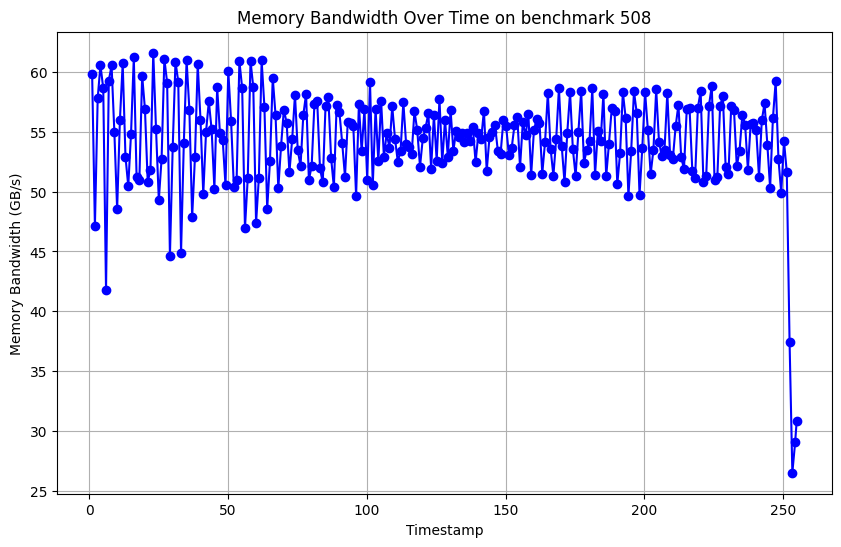

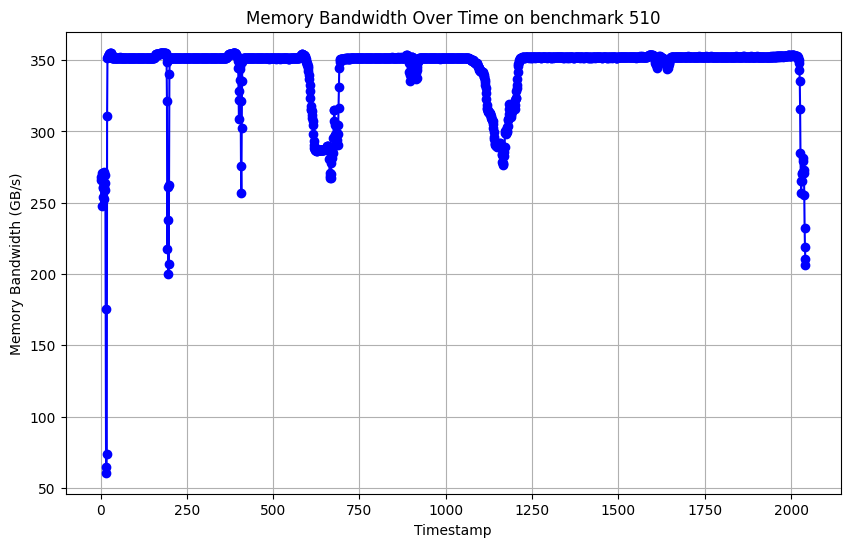

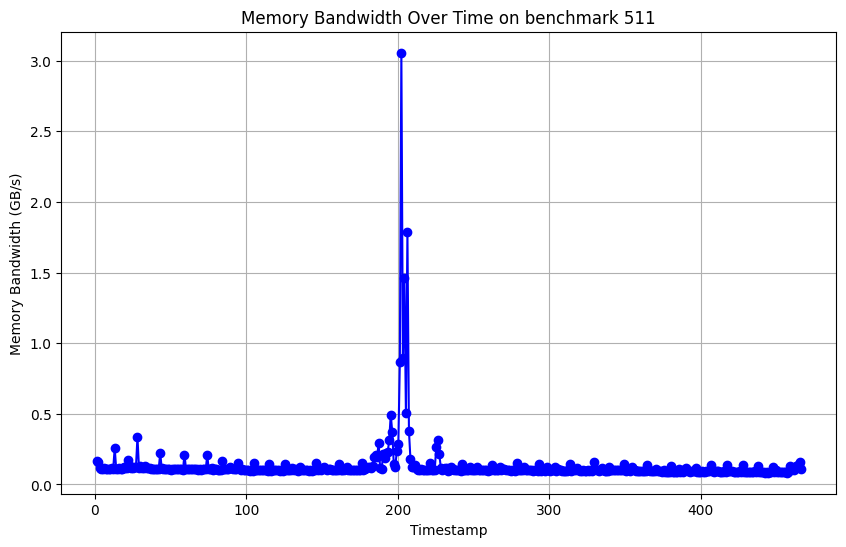

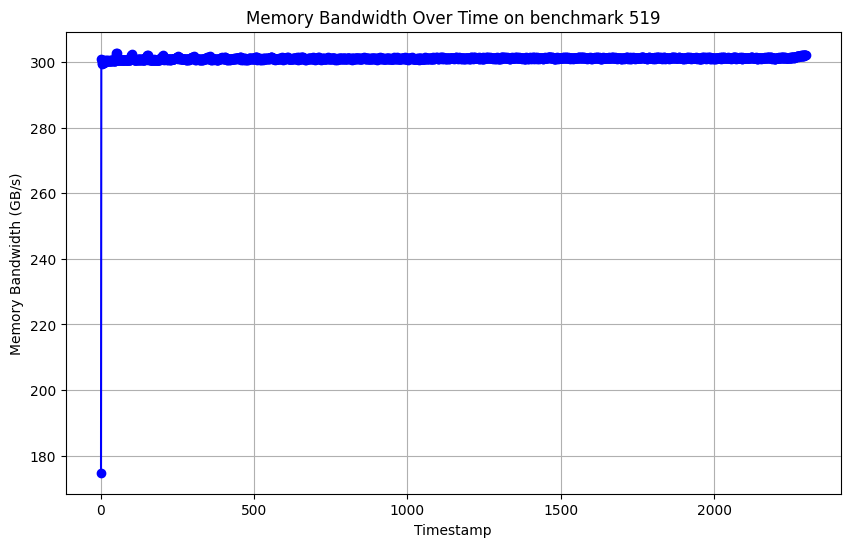

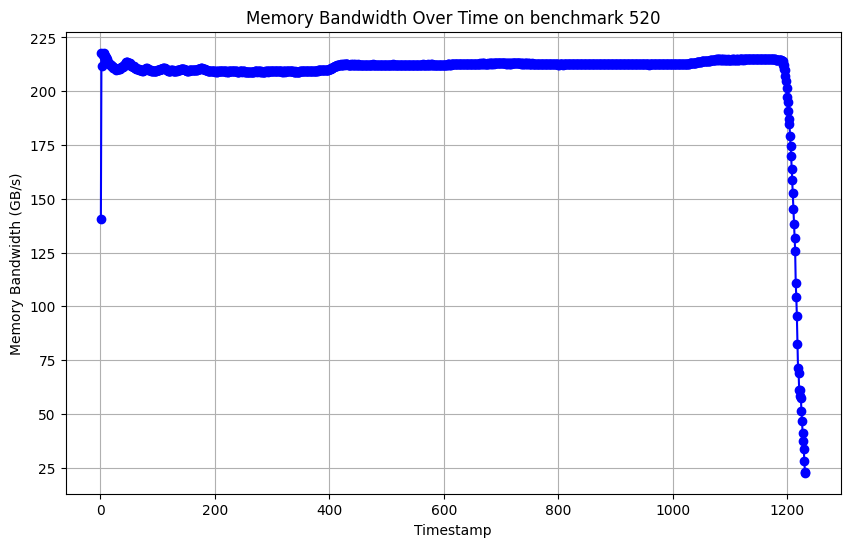

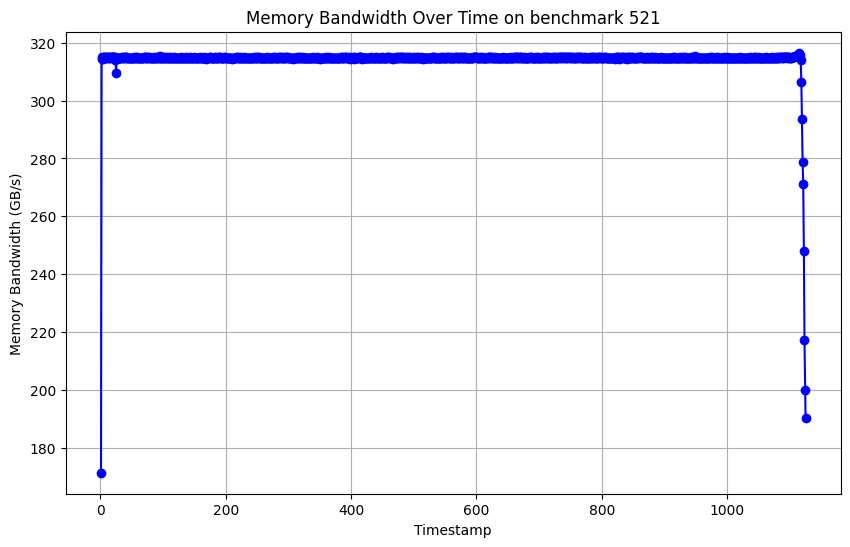

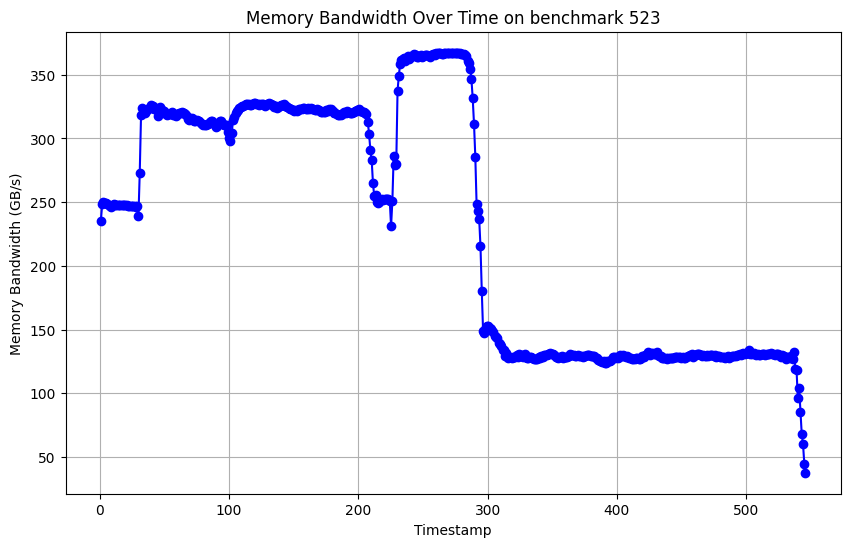

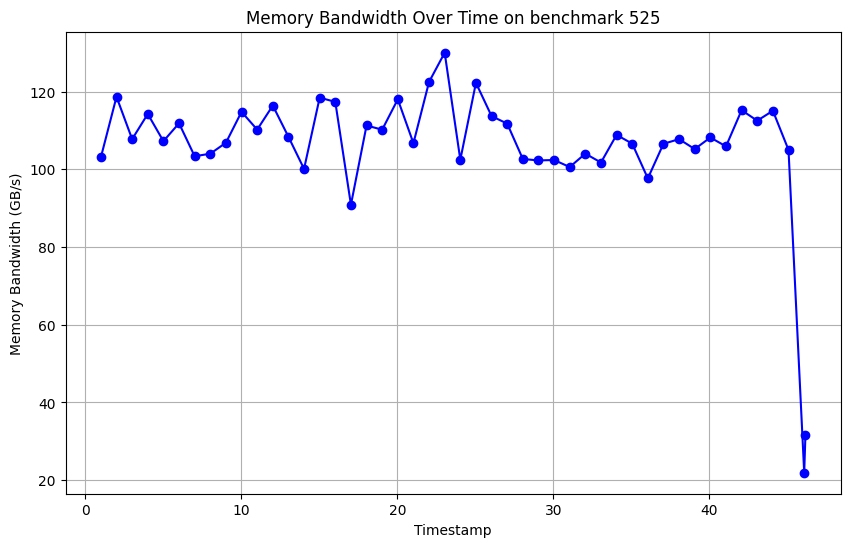

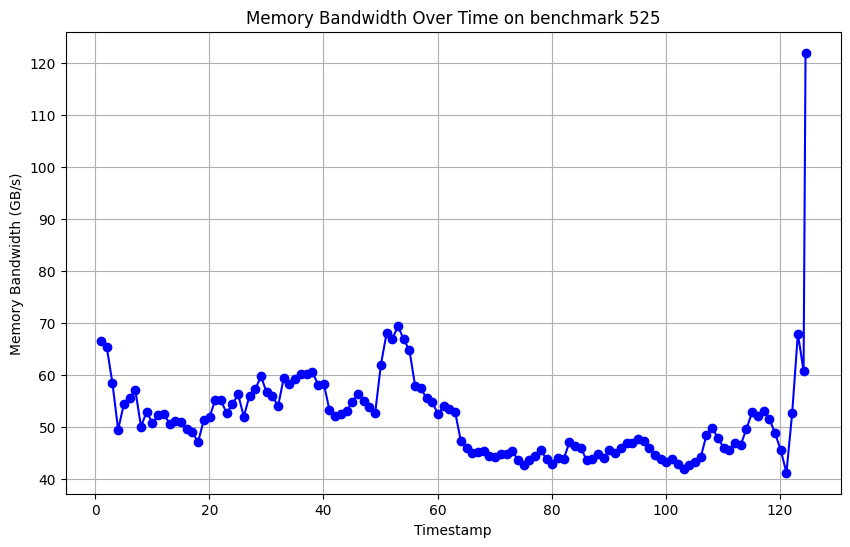

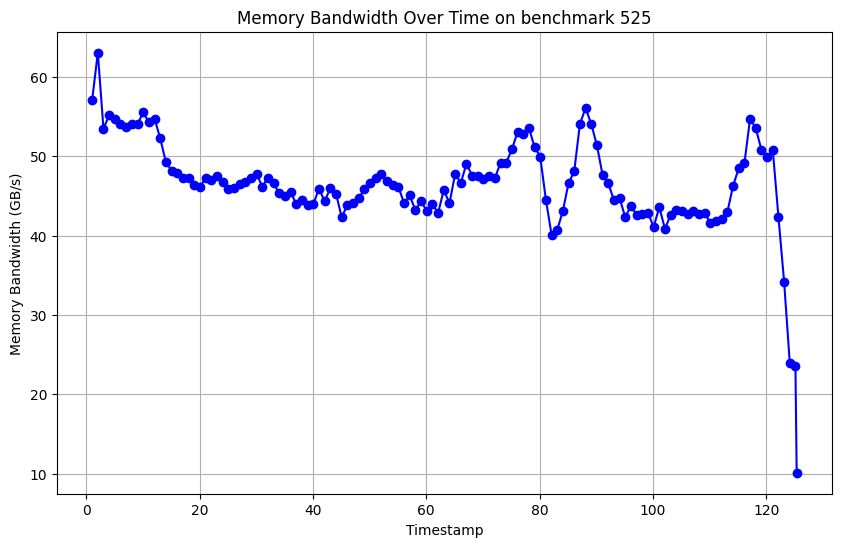

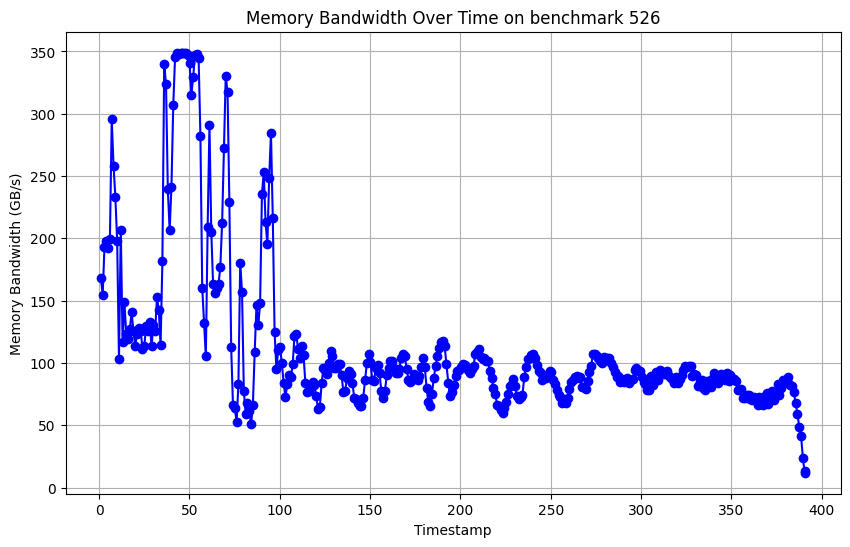

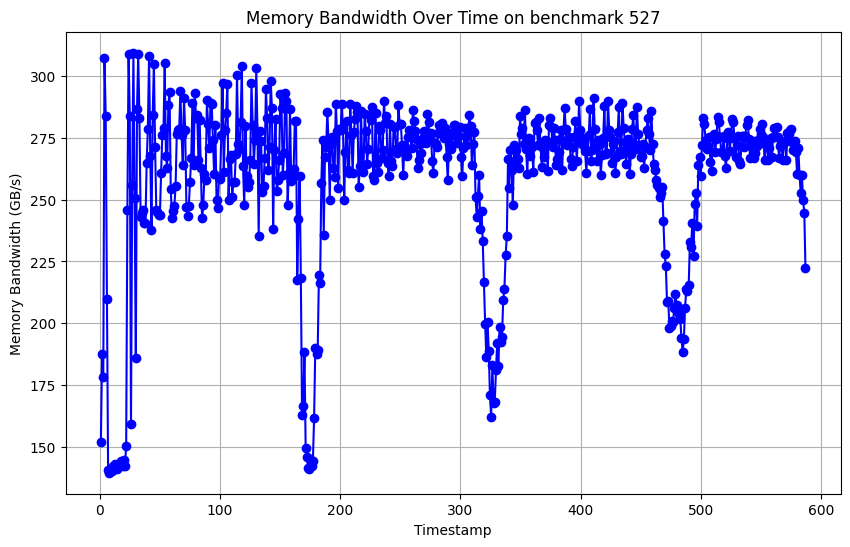

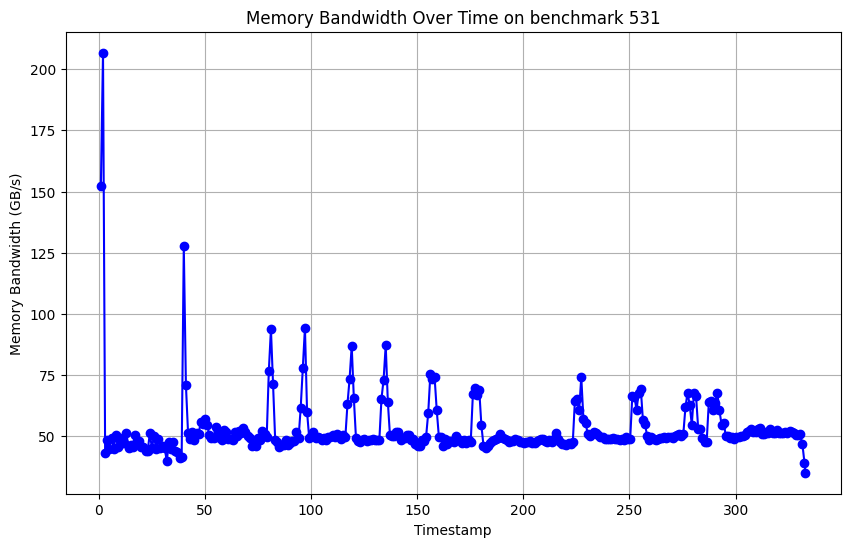

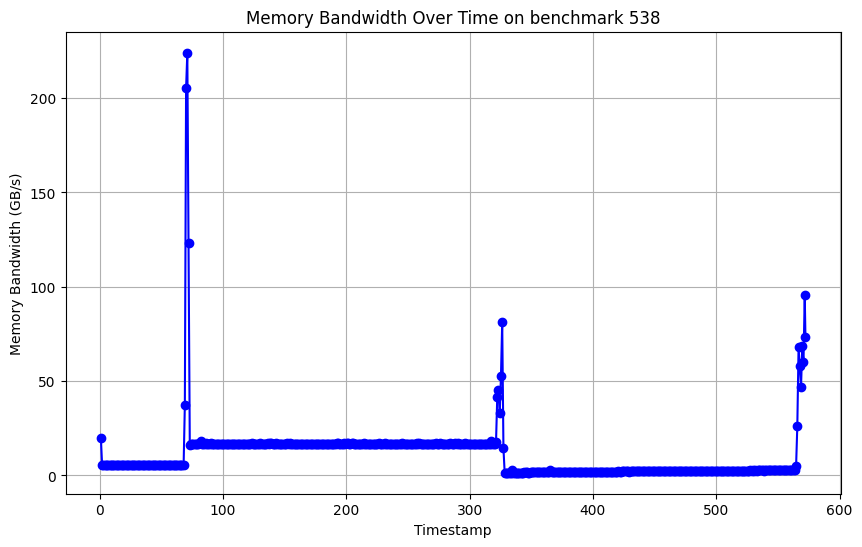

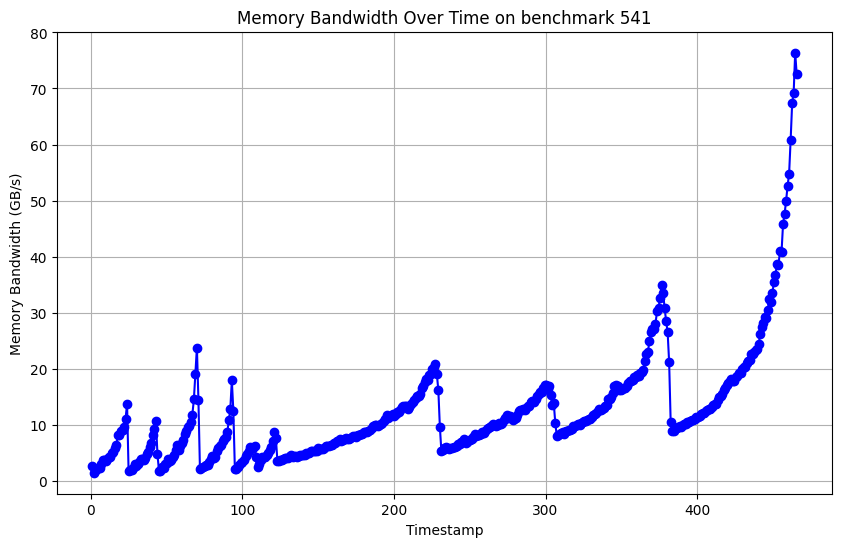

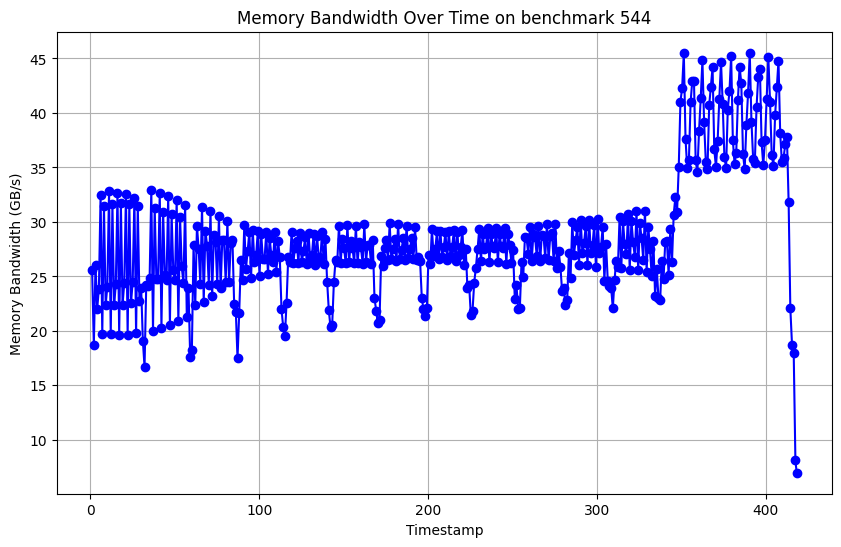

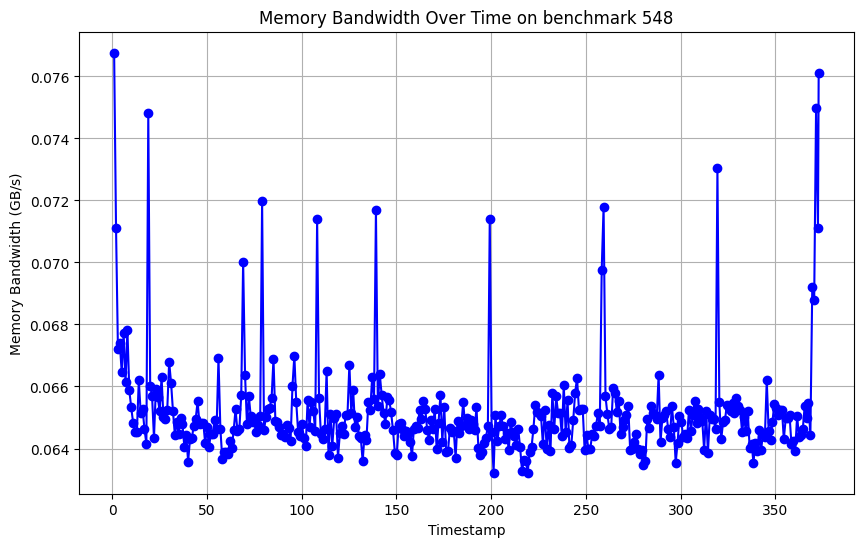

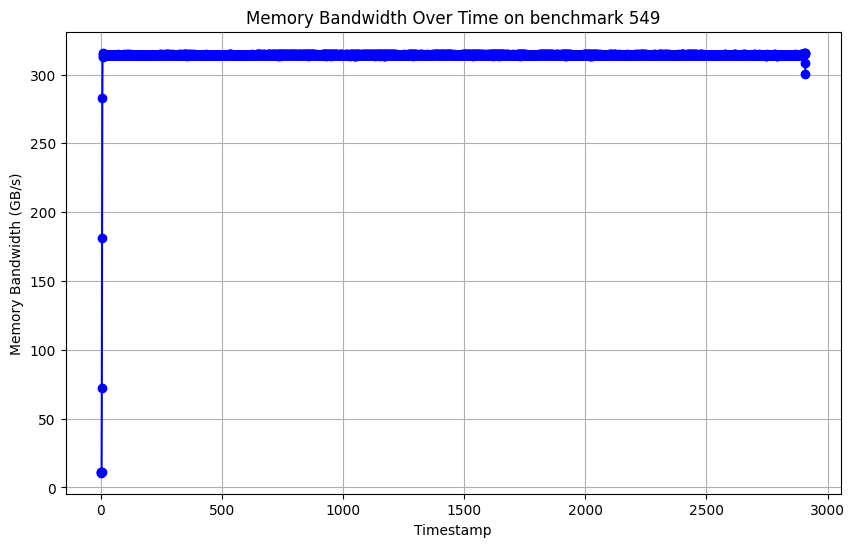

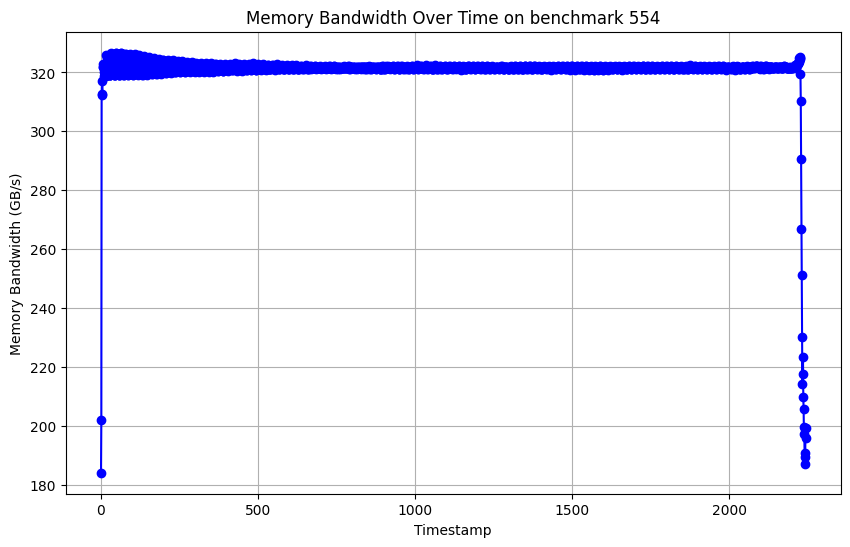

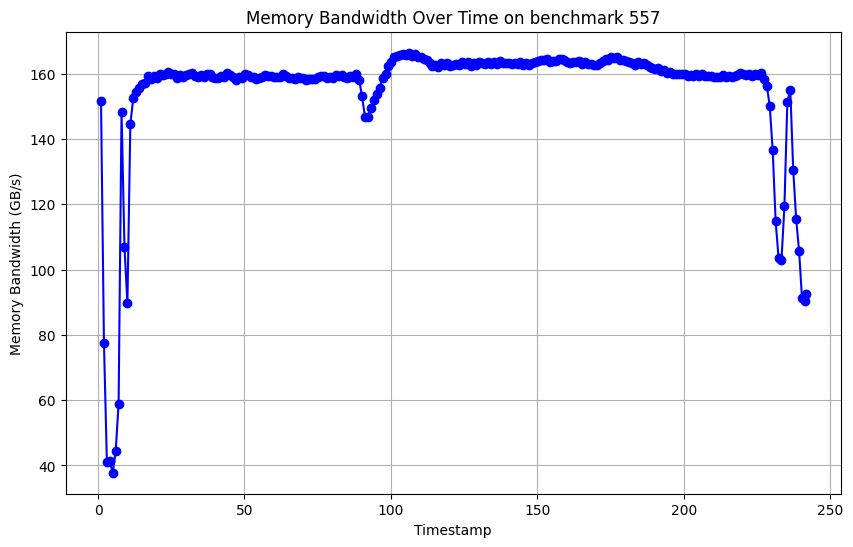

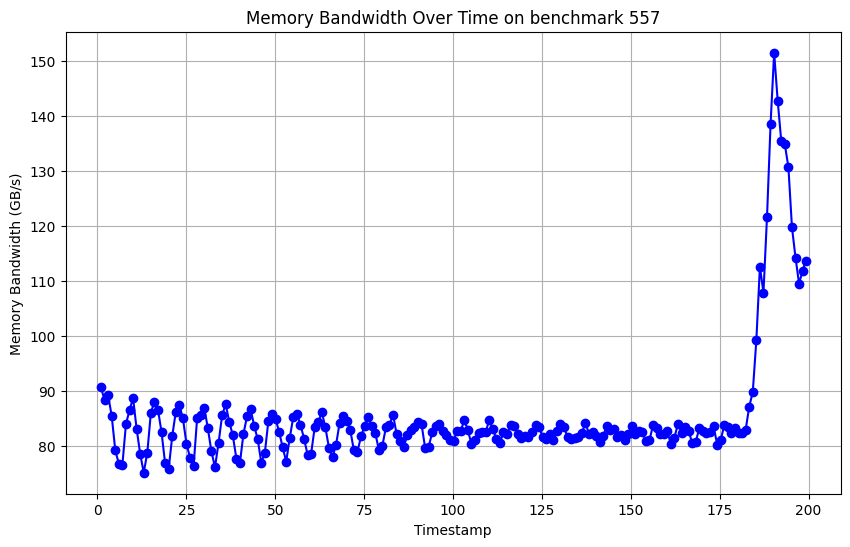

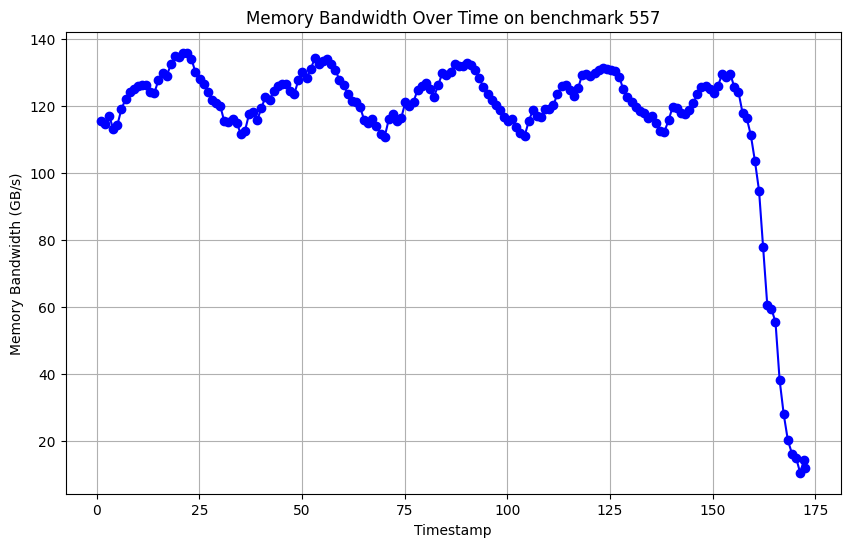

In [ ]:
for data_csv in files:
    perf_raw_path = csv_dir + data_csv
    perf_raw_data = pd.read_csv(perf_raw_path,
                                sep='|',
                                header=None, 
                                names=["timestamp", "value", "event"], 
                                usecols=[0, 1, 3])
    perf_raw_data['type'] = perf_raw_data['event'].apply(
        lambda x: 'read' if x[-2:-1] == '0' else 'write'
    )
    perf_raw_data['device_id'] = perf_raw_data['event'].apply(
        lambda x: x[11:20]
    )
    perf_raw_data['socket'] = perf_raw_data['device_id'].apply(
        lambda x: 0 if x[0] == '1' else '1'
    )
    
    bw_all = perf_raw_data.groupby(['timestamp']).agg(value=('value', 'sum')).reset_index()

    bw_all['interval'] = bw_all['timestamp'].diff()
    bw_all.loc[0, 'interval'] = bw_all.loc[0, 'timestamp']

    bw_all['memory bandwidth (GB/s)'] = (bw_all['value'] * 64) / (bw_all['interval'] * 1000000000)


    perf_raw_data = perf_raw_data.drop('event', axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(bw_all['timestamp'], bw_all['memory bandwidth (GB/s)'], marker='o', linestyle='-', color='b')
    plt.title('Memory Bandwidth Over Time on benchmark ' + data_csv.split(".")[0])
    plt.xlabel('Timestamp')
    plt.ylabel('Memory Bandwidth (GB/s)')
    plt.grid(True)
    plt.savefig(f'../data/images/dmc_620/{data_csv.split(".")[0] + ".png"}')